In [7]:
import os, sys, re
import numpy as np
import numpy.ma as ma
from math import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import fit_beta as fb
import scipy.special as ss
import bisect
from ipywidgets import *
from tqdm.notebook import tqdm

In [8]:
def qfunbeta(alpha,beta,a,b,P):
    return ss.betaincinv(alpha,beta,P)*(b-a)+a

def quantilesetbeta(n,alpha,beta,a,b):
    pvalues = [(i+1.0-0.3)/(n+0.4) for i in range(n)]
    qvalues = [qfunbeta(alpha,beta,a,b,p) for p in pvalues]
    return pvalues, qvalues

def pdfbeta(n,alpha,beta,a,b):
    xvalues = [a+(b-a)/(n-1)*i for i in range(n)]
    qvalues = [(x-a)**(alpha-1 )*((b-x)**(beta-1))/(b-a)/ss.beta(alpha,beta)   for x in xvalues]
    return xvalues, qvalues

#define distribution function and quantile function for the Beta distribution
def beta_forward(alpha,beta,a,b,y):
    if (y<a):
        return 0.0
    elif (y>b):
        return 1.0
    else:
        return(ss.betainc(alpha,beta,(y-a)/(b-a)))

def beta_reverse(alpha,beta,a,b,p):
    return(ss.betaincinv(alpha,beta,p)*(b-a)+a)

def P_from_Beta(beta):
    return (0.5+0.5*ss.erf(beta/(2**0.5)))
def Q_from_Beta(beta):
    return (0.5+0.5*ss.erf(-beta/(2**0.5)))
def Beta_from_Q(Q):
    return(-ss.erfinv(2*Q - 1.0)*(2**0.5))
def Beta_from_P(Q):
    return(ss.erfinv(2*Q - 1.0)*(2**0.5))

def quantileplot(ensembles, results, lbl):
    q_obs = sorted(ensembles[lbl])
    n_obs = len(q_obs)
    result = results[lookup[lbl]]
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    pvalues, q_fit = quantilesetbeta(n_obs,alpha,beta,a,b)
    mysample = np.array(quantilesetbeta(n_obs,alpha,beta,a,b))             # exact quantiles (order statistics) for the given parameters
    plt.plot(pvalues,q_obs,'+',pvalues,q_fit,'r-')

def pdfplot_duo(ax, results_m, lbl):
    result = results_m[lbl]
    n_obs=1000
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    xvalues, q_pdf_m = pdfbeta(n_obs,alpha,beta,a,b)

    alpha = result['estimate2'][0]
    beta = result['estimate2'][1]
    a = result['estimate2'][2]
    b = result['estimate2'][3]
    xvalues, q_pdf_q = pdfbeta(n_obs,alpha,beta,a,b)
    ax.plot(xvalues,q_pdf_m,'r-',xvalues,q_pdf_q,'g-')        
    
def quantileplot_duo(ax, ensembles, results_m, lbl):
    q_obs = sorted(ensembles[lbl])
    n_obs = len(q_obs)
    result = results_m[lbl]
    alpha = result['estimate'][0]
    beta = result['estimate'][1]
    a = result['estimate'][2]
    b = result['estimate'][3]
    pvalues, q_fit_m = quantilesetbeta(n_obs,alpha,beta,a,b)

    alpha = result['estimate2'][0]
    beta = result['estimate2'][1]
    a = result['estimate2'][2]
    b = result['estimate2'][3]
    pvalues, q_fit_q = quantilesetbeta(n_obs,alpha,beta,a,b)
    
    mysample = np.array(quantilesetbeta(n_obs,alpha,beta,a,b))             # exact quantiles (order statistics) for the given parameters
    ax.plot(pvalues,q_obs,'b+',label="Sample")    
    ax.plot(pvalues,q_fit_m,'r-',label="Fit Moments")    
    ax.plot(pvalues,q_fit_q,'g-',label="Fit Quantile")    
    ax.set_xlabel('P-value [-]')
    ax.set_ylabel('Percentile [m3 s-1]')    
    ax.legend()
    ax.set_title("Fits, percentiles versus P-value")
    
def linfit(x,y):
    nn = ma.count(x)
    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
    return(c)

def interpolate(xx,yy,x,default=np.nan):
    if x<xx[0] or x>xx[-1]:
        return default
    for i in range(len(xx)-1):
        if (x>=xx[i] and x<=xx[i+1]):
            w=(x-xx[i])/(xx[i+1]-xx[i])
            return (1.-w)*yy[i] + w*yy[i+1]    

In [9]:
# Visualisation of the Beta pdf
x = np.linspace(0.0001, 1-0.0001,500)
alpha = 4.
beta = 2.
#fig = plt.figure(figsize=(9,5))
#ax1 = fig.add_subplot(1, 1, 1)
#line1, = ax1.plot(x, x**(alpha-1)*(1-x)**(beta-1)/sc.beta(alpha,beta))
#ax1.set_title("Probability density")

#def update2(alpha=widgets.FloatSlider(min=0.01, max=50, step=0.01, value=2.0, continuous_update=False), beta=widgets.FloatSlider(min=0.01, max=50, step=0.1, value=2.0, continuous_update=False)):
def update2(alpha=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.01, value=2.0, continuous_update=False), beta=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.1, value=2.0, continuous_update=False)):
    fig = plt.figure(figsize=(5,9))
    ax1 = fig.add_subplot(1, 1, 1)
    line1 = ax1.plot(x**(alpha-1)*(1-x)**(beta-1)/ss.beta(alpha,beta),x)
    modus = (alpha-1)/(alpha+beta-2)
    at_modus = modus**(alpha-1)*(1-modus)**(beta-1)/ss.beta(alpha,beta)
    line2 = ax1.plot([0,at_modus],[modus,modus],'r--')
    return (plt.gca)
    
interact(update2)

interactive(children=(FloatLogSlider(value=2.0, continuous_update=False, description='alpha', max=3.0, min=-2.…

<function __main__.update2(alpha=FloatLogSlider(value=2.0, continuous_update=False, description='alpha', max=3.0, min=-2.0, step=0.01), beta=FloatLogSlider(value=2.0, continuous_update=False, description='beta', max=3.0, min=-2.0))>

In [10]:
# Load ensembles into dictionaries
# Read the file into a dictionary, labelled by event->timeseries
datafile = 'read_Qmax_sums_results.csv'
sep = ';'
with open(datafile,"r") as fnin:
    line = fnin.readline().strip()
    colnames = re.sub(r'[^\x00-\x7F]','', line).split(sep)
    ensembles = { colname:[] for colname in colnames}
    while line:
        line = fnin.readline()
        linesplit = line.strip().split(sep)
        for i in range(len(linesplit)):
            if linesplit[i]:
                try:
                    ensembles[colnames[i]].append(float(linesplit[i].replace(',','.')))
                except:
                    ensembles[colnames[i]].append(linesplit[i])


In [11]:
# Select realizations from ensembles:
first_realization = 0
last_realization = 100
refnr = 113

label2nr = {}
rownames = ensembles['Scenario']
for i in range(len(rownames)):
    label2nr[rownames[i]] = i
selected = ['Sum%d'%dd for dd in range (first_realization,last_realization+1)]    # selected labels for realizations
selnr = [label2nr[rowname] for rowname in selected]

In [47]:
# Determine min, max, alpha, beta for each ensemble
irow_ref = label2nr['Sum%d'%refnr]
results_m = {}
for icol in range(1,len(colnames)): 
    standard=ensembles[colnames[icol]][irow_ref]
    sample=np.array([ensembles[colnames[icol]][i] for i in selnr])
    est,var = fb.fitBetaMomentsJack(sample)
    est2 = fb.fitBetaQuantiles(sample)
    results_m[colnames[icol]]={'estimate': est, 'variance':var, 'estimate2': est2, 'standard': standard}
    # print ens
results_m

{'b24000': {'estimate': array([3.71201092e+00, 2.09194231e+00, 1.36151434e+04, 1.94626733e+04]),
  'variance': array([4.66230807e+02, 9.11719143e+01, 7.76791586e+07, 1.15720196e+07]),
  'estimate2': array([5.88944016e+00, 2.86022317e+00, 1.27065201e+04, 1.96720907e+04]),
  'standard': 17553.9082},
 'maxQ_14199_maxV_28.8_year_3345': {'estimate': array([2.62803492e+00, 1.50100758e+00, 1.34128150e+04, 1.57452037e+04]),
  'variance': array([1.10390730e+02, 2.37699788e+01, 1.16280491e+07, 6.57534541e+05]),
  'estimate2': array([2.23925333e+00, 1.25151723e+00, 1.35178758e+04, 1.56799612e+04]),
  'standard': 14902.15723},
 'maxQ_14210_maxV_18.1_year_2288': {'estimate': array([1.77462458e+00, 1.56257231e+00, 1.37093245e+04, 1.68417201e+04]),
  'variance': array([3.33856108e+01, 2.25561479e+01, 6.23916647e+06, 2.01549973e+06]),
  'estimate2': array([1.81385827e+00, 1.57018206e+00, 1.37016274e+04, 1.68278785e+04]),
  'standard': 15286.16699},
 'maxQ_14256_maxV_11.5_year_3236': {'estimate': array

In [47]:
a = np.array([])
b = np.array([])
alpha = np.array([])
beta = np.array([])
std = np.array([])

a_2se = np.array([])
b_2se = np.array([])
alpha_2se = np.array([])
beta_2se = np.array([])

lbl = []
for label in results_m.keys():
    std = np.append(std,results_m[label]['standard'])
    alpha = np.append(alpha,results_m[label]['estimate'][2])
    beta = np.append(beta,results_m[label]['estimate'][3])
    a = np.append(a,results_m[label]['estimate'][0])
    b = np.append(b,results_m[label]['estimate'][1])
    alpha_2se = np.append(alpha,results_m[label]['variance'][2])
    beta_2se = np.append(beta,results_m[label]['variance'][3])
    a_2se = np.append(a,results_m[label]['variance'][0])
    b_2se = np.append(b,results_m[label]['variance'][1])
    lbl.append(label)

sys.stdout.write("%11s    %8s %8s       %8s    %8s    %s\n"%('Ref','alpha','beta','A', 'B', 'Label'))
for i in range(len(lbl)):
    sys.stdout.write("%8.5f    %8.5f %8.5f    %8.5f %8.5f    %s\n"%(std[i],a[i],b[i],alpha[i],beta[i],lbl[i]))

        Ref       alpha     beta              A           B    Label
17553.90820     3.71201  2.09194    13615.14343 19462.67328    b24000
14902.15723     2.62803  1.50101    13412.81502 15745.20368    maxQ_14199_maxV_28.8_year_3345
15286.16699     1.77462  1.56257    13709.32447 16841.72014    maxQ_14210_maxV_18.1_year_2288
13351.64551     2.03466  1.06650    11795.17034 14115.33281    maxQ_14256_maxV_11.5_year_3236
14307.43555     1.61699  1.45716    12767.70517 15810.41097    maxQ_14434_maxV_14.1_year_3126
14193.20605     1.33763  1.48444    13180.73558 15434.22470    maxQ_14450_maxV_23.4_year_3048
14482.79395     1.45828  1.46577    13095.98703 15817.19115    maxQ_14567_maxV_18.9_year_7445
15096.23535     1.54703  1.60232    13823.27269 16404.51866    maxQ_14594_maxV_23.3_year_9987
14179.44336     1.64708  1.55112    12614.64039 15610.31952    maxQ_14756_maxV_14.5_year_7191
14396.85254     2.01663  2.02840    13369.75899 15641.03664    maxQ_14808_maxV_23.1_year_9093
14611.16504    

<H2>Results Quantile Fits</H2>

In [13]:
def readTEKAL(fnin,blklbl):
# Read selected TEKAL block in a list of numpy 1d-arrays
    with open(fnin,"r") as fn:
        line = "."
        while line:
            line = fn.readline()
            if line.strip()==blklbl:
                nrowcol = fn.readline().split()
                nrow, ncol = int(nrowcol[0]), int(nrowcol[1])
                break
        data =[]   # list of numpy arrays
        for icol in range(ncol):
            data.append(np.array([]))
        for irow in range(nrow):
            strings = fn.readline().split()
            for icol in range(ncol):
                data[icol] = np.append(data[icol],float(strings[icol]))
            
    return data

def read_parameter_table(fnin):
    # Ref.Value         a             b           alpha         beta          Mean         Median         Modus        Spread       Skewness      L2-CostFunc. Mean(Resid's) RMS(Residuals) Spr.Red.Fact. Eqv.Cor.Coef"
    blok0 = readTEKAL(fnin,'BL00')
    nrow = len(blok0[0])
    results = [{'estimate':[blok0[3][irow],blok0[4][irow],blok0[1][irow],blok0[2][irow]], 'standard': blok0[0][irow]} for irow in range(nrow)]
    return results

def read_quantile_block(fnin,blklbl):
    blkdata = readTEKAL(fnin,blklbl)

In [14]:
result_file = 'read_Qmax_sums_results.out.tek'
results_q = read_parameter_table(result_file)
labels = [lbl for lbl in results_m.keys()]
for i in range(len(results_q)):
    results_m[labels[i]]['estimate0'] = results_q[i]['estimate']
    results_m[labels[i]]['standard0'] = results_q[i]['standard']
    

In [17]:
parameterlist =  ({rec['standard']:{'estimate0': rec['estimate0'], 'estimate': rec['estimate'], 'variance': rec['variance'], 'estimate2': rec['estimate2'] } for key,rec in results_m.items()})

In [37]:
reference = sorted(parameterlist.keys())
alpha0 = np.array([parameterlist[ref]['estimate0'][0] for ref in reference])     
alpha1 = np.array([parameterlist[ref]['estimate'][0] for ref in reference])     
alpha2 = np.array([parameterlist[ref]['estimate2'][0] for ref in reference])     

beta0 = np.array([parameterlist[ref]['estimate0'][1] for ref in reference])     
beta1 = np.array([parameterlist[ref]['estimate'][1] for ref in reference])     
beta2 = np.array([parameterlist[ref]['estimate2'][1] for ref in reference])     

a0 = np.array([parameterlist[ref]['estimate0'][2] for ref in reference])     
a1 = np.array([parameterlist[ref]['estimate'][2] for ref in reference])     
a2 = np.array([parameterlist[ref]['estimate2'][2] for ref in reference])     

b0 = np.array([parameterlist[ref]['estimate0'][3] for ref in reference])     
b1 = np.array([parameterlist[ref]['estimate'][3] for ref in reference])     
b2 = np.array([parameterlist[ref]['estimate2'][3] for ref in reference])

alpha1_2se = np.array([2.*(parameterlist[ref]['variance'][0]**0.5) for ref in reference])     
beta1_2se = np.array([2.*(parameterlist[ref]['variance'][1]**0.5) for ref in reference])     
a1_2se = np.array([2.*(parameterlist[ref]['variance'][2]**0.5) for ref in reference])     
b1_2se = np.array([2.*(parameterlist[ref]['variance'][3]**0.5) for ref in reference])     


qref = np.array(reference)

array([  0.984939,   1.20002 ,   1.5209  ,   1.55726 ,   1.38025 ,
         1.39158 ,   1.92156 ,   1.46764 ,   1.41766 ,   4.26894 ,
         2.36303 ,   1.25151 ,   3.63399 ,   1.89976 ,   2.9464  ,
         1.67601 ,   2.8725  ,   3.33042 ,   1.60402 ,   1.92156 ,
         3.14116 ,   1.57018 ,   1.85373 ,   2.05155 ,   1.02029 ,
         2.02844 ,   2.15726 ,   2.146   ,   1.1392  ,   2.29647 ,
         1.26576 ,   2.71489 ,   1.95383 ,   2.64639 ,   1.40229 ,
         0.882585,   0.904829,   1.62492 ,   1.98191 ,   1.07976 ,
         1.13888 ,   1.23566 ,   1.54205 ,   1.85473 ,   4.87809 ,
         1.30727 ,   5.75995 , 206.599   ,   3.28695 ,   2.86019 ,
         3.16103 ])

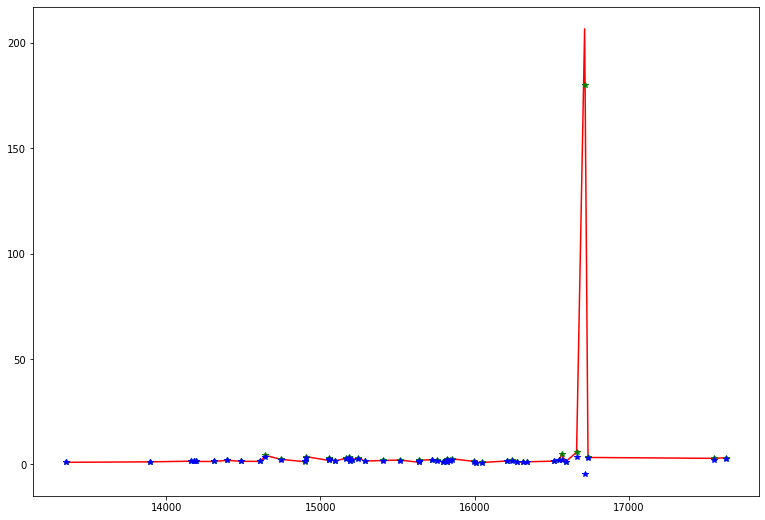

In [68]:
plt.plot(qref,beta0,'r-')
plt.plot(qref,beta2,'g*')
plt.plot(qref,beta1,'b*')
ax=plt.gca()

fg=plt.gcf()
fg.set_size_inches(13,9)
beta0

In [52]:
ensemble_abcissa = np.array([])
ensemble_ordinate = np.array([])
ensemble_names=[key for key in ensembles.keys()]
for i in range(1,len(ensemble_names)):
    for ensemble_value in ensembles[ensemble_names[i]]:
        ensemble_abcissa = np.append(ensemble_abcissa,std[i-1])
        ensemble_ordinate = np.append(ensemble_ordinate,ensemble_value)

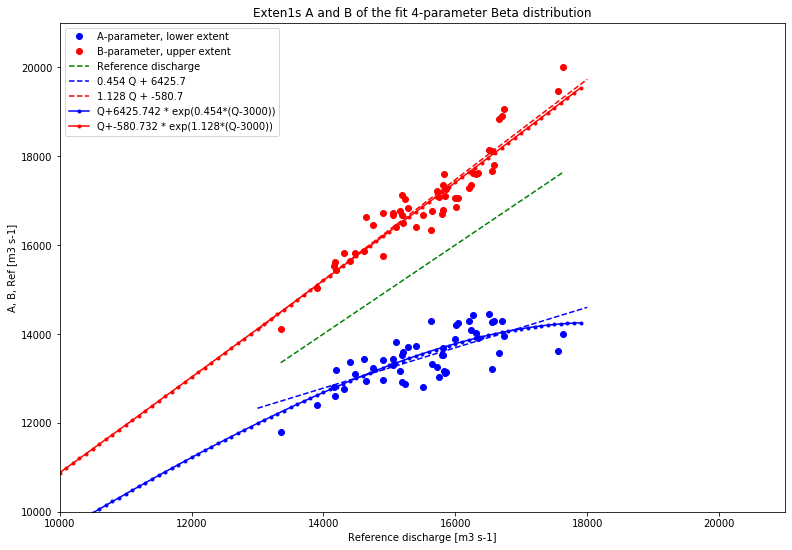

In [53]:
# linear fits
c_a1 = linfit(qref,a1)
c_b1 = linfit(qref,b1)

# logarithmic fits
q0 = 3000
clog_a1 = linfit(qref-q0,np.log(qref-a1))
clog_b1 = linfit(qref-q0,np.log(b1-qref))

plt.plot(qref,a1,'bo',label='A-parameter, lower extent')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')

ax.set_xlim([10000,21000])
# linear fits
qs=np.array([13000,18000])
ax.plot(qs,qs*c_a1[0]+c_a1[1],'b--',label="%.3f Q + %.1f"%tuple(c_a1))
ax.plot(qs,qs*c_b1[0]+c_b1[1],'r--',label="%.3f Q + %.1f"%tuple(c_b1))

#logarithmic fits
qs=np.array(list(range(3000,18000,100)))
ax.plot(qs,qs-np.exp(clog_a1[0]*(qs-q0)+clog_a1[1]),'b.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_a1[1],c_a1[0],q0))
ax.plot(qs,qs+np.exp(clog_b1[0]*(qs-q0)+clog_b1[1]),'r.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_b1[1],c_b1[0],q0))

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Exten1s A and B of the fit 4-parameter Beta distribution')
ax.legend()



In [54]:
def linfit(x,y):
    nn = ma.count(x)
    c = [(ma.sum(x*y)-ma.sum(x)*ma.sum(y)/nn)/(ma.sum(x*x)-ma.sum(x)*ma.sum(x)/nn)]
    c.append((ma.sum(y)-c[0]*ma.sum(x))/nn)
    return(c)


# linear fits for the quantile fits, method 2 
masked = [-7,-4]
a2_ma=ma.masked_array(a2)
a2_ma.mask=[]
b2_ma=ma.masked_array(b2)
b2_ma.mask=[]
qref_ma = ma.masked_array(qref)
qref_ma.mask=[]
a2_ma.mask[masked] = True
b2_ma.mask[masked] = True
qref_ma.mask[masked] = True

c_a2 = linfit(qref_ma,a2_ma)
c_b2 = linfit(qref_ma,b2_ma)


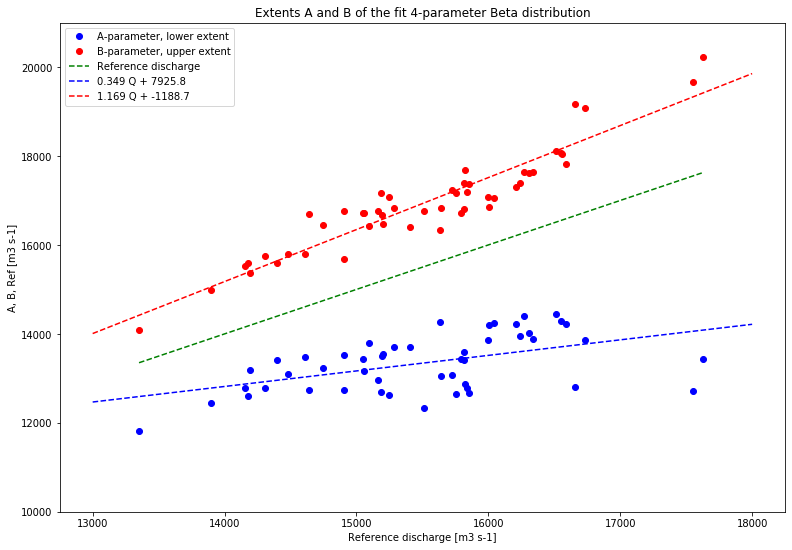

In [55]:
plt.plot(qref,a2,'bo',label='A-parameter, lower extent')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,b2,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')

qs=np.array([13000,18000])
ax.plot(qs,qs*c_a2[0]+c_a2[1],'b--',label="%.3f Q + %.1f"%tuple(c_a2))
ax.plot(qs,qs*c_b2[0]+c_b2[1],'r--',label="%.3f Q + %.1f"%tuple(c_b2))

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')
ax.legend()



<class 'numpy.ndarray'>
6862.04


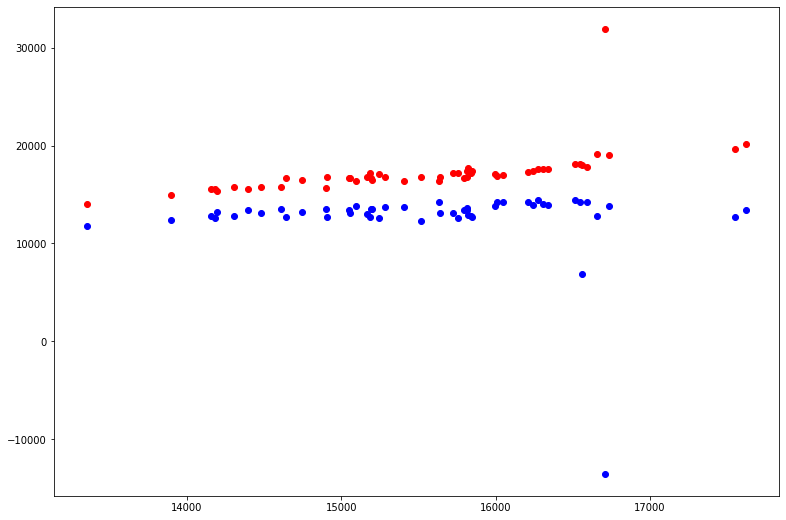

In [56]:
print(type(a2))
# linear fits for the quantile fits, method 2 
print(a2[-7])
c_a2 = linfit(qref,a2)
c_b2 = linfit(qref,b2)

plt.plot(qref,a2,'bo',label='A-parameter, lower extent')
plt.plot(qref,b2,'ro',label='B-parameter, lower extent')
fig = plt.gcf()

fig.set_size_inches(13,9)


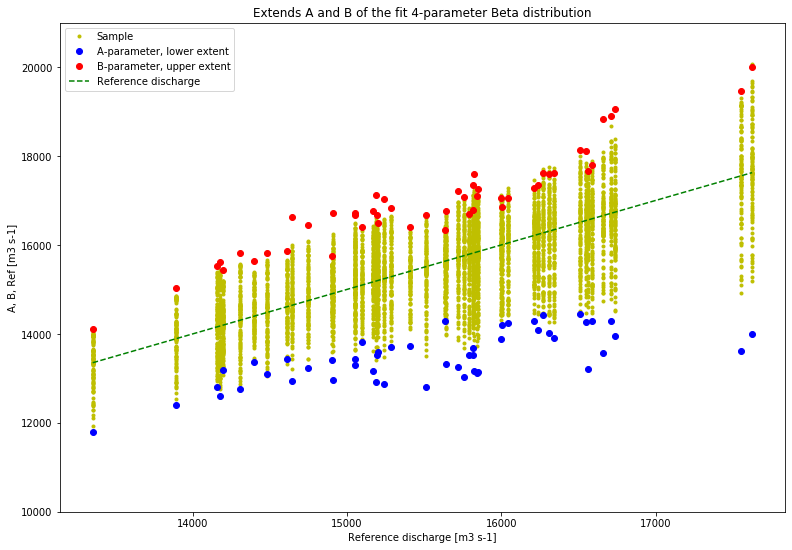

In [57]:
plt.plot(ensemble_abcissa,ensemble_ordinate,'y.',label='Sample')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,a1,'bo',label='A-parameter, lower extent')
ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extends A and B of the fit 4-parameter Beta distribution')
ax.legend()




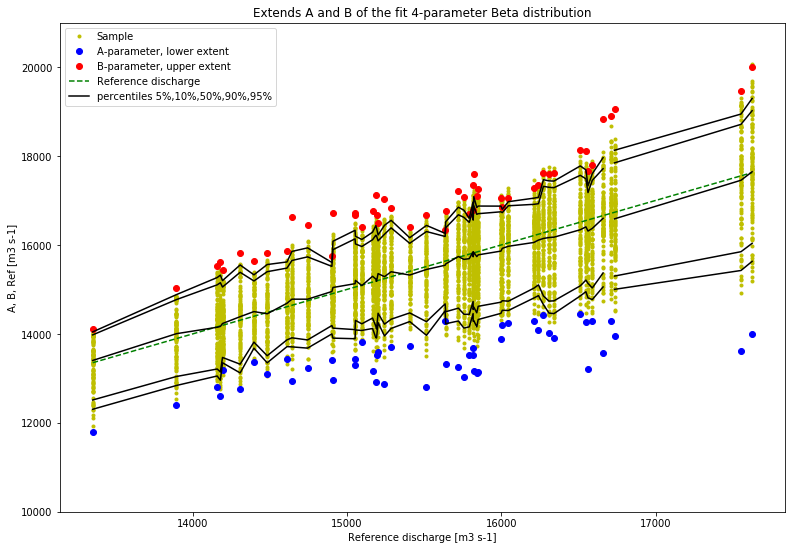

In [58]:
pct5=np.array([qfunbeta(alpha1[i],beta1[i],a1[i],b1[i],0.05) for i in range(np.size(a1))])
pct10=np.array([qfunbeta(alpha1[i],beta1[i],a1[i],b1[i],0.10) for i in range(np.size(a1))])
pct50=np.array([qfunbeta(alpha1[i],beta1[i],a1[i],b1[i],0.50) for i in range(np.size(a1))])
pct90=np.array([qfunbeta(alpha1[i],beta1[i],a1[i],b1[i],0.90) for i in range(np.size(a1))])
pct95=np.array([qfunbeta(alpha1[i],beta1[i],a1[i],b1[i],0.95) for i in range(np.size(a1))])

plt.plot(ensemble_abcissa,ensemble_ordinate,'y.',label='Sample')
fig = plt.gcf()
ax=plt.gca()
ax.set_ylim([10000,21000])
ax.plot(qref,a1,'bo',label='A-parameter, lower extent')
ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')
ax.plot(qref,pct5,'k-',label='percentiles 5%,10%,50%,90%,95%')
ax.plot(qref,pct10,'k-')
ax.plot(qref,pct50,'k-')
ax.plot(qref,pct90,'k-')
ax.plot(qref,pct95,'k-')

fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extends A and B of the fit 4-parameter Beta distribution')
ax.legend()




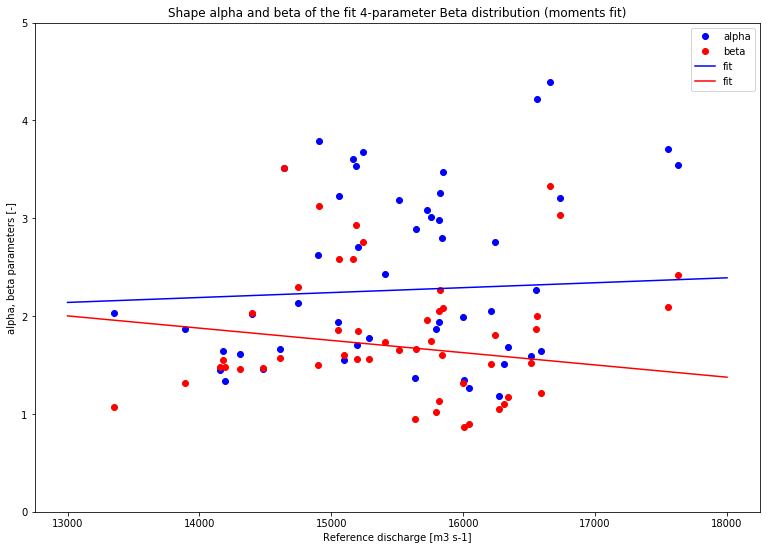

In [59]:
#plt.plot(qref,alpha1,'bo',qref,beta1,'ro',qref,alpha2,'b+',qref,beta2,'r+')

# linear fits
c_alpha1 = linfit(qref,alpha1)
c_beta1 = linfit(qref,beta1)
c_alpha2 = linfit(qref,alpha2)
c_beta2 = linfit(qref,beta2)

plt.plot(qref,alpha1,'bo',label="alpha")
fig = plt.gcf()
fig.set_size_inches(13,9)
plt.plot(qref,beta1,'ro',label="beta")

qs=np.array([13000,18000])
plt.plot(qs,qs*c_alpha1[0]+c_alpha1[1],'b-',label="fit")
plt.plot(qs,qs*c_beta1[0]+c_beta1[1],'r-',label="fit")

ax=plt.gca()
ax.set_ylim([0,5])
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('alpha, beta parameters [-]')
ax.set_title('Shape alpha and beta of the fit 4-parameter Beta distribution (moments fit)')

ax.legend()

In [60]:
qr = 13000
qr_min = 13000
qr_max = 21000

def update3(qr=widgets.FloatSlider(min=qr_min, max=qr_max, step=100, value=15000, continuous_update=False)):
    fig = plt.figure()
    fig.set_size_inches(13,9)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(qref,a1,'bo',label='A-parameter, lower extent')
    ax.set_ylim([10000,30000])
    ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
    ax.plot(qref,qref,'g--',label='Reference discharge')

    qs=np.array([qr_min,qr_max])
    ax.plot(qs,qs*c_a1[0]+c_a1[1],'b--',label="%.3f Q + %.1f"%tuple(c_a1))
    ax.plot(qs,qs*c_b1[0]+c_b1[1],'r--',label="%.3f Q + %.1f"%tuple(c_b1))

    ax.set_xlabel('Reference discharge [m3 s-1]')
    ax.set_ylabel('A, B, Ref [m3 s-1]')
    ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')

    x = np.linspace(0.0001, 1-0.0001,500)
    alpha = qr*c_alpha1[0]+c_alpha1[1]
    beta = qr*c_beta1[0]+c_beta1[1]
    AA = qr*c_a1[0]+c_a1[1]
    BB = qr*c_b1[0]+c_b1[1]
    line1 = plt.plot(qr+500*x**(alpha-1)*(1-x)**(beta-1)/ss.beta(alpha,beta),(BB-AA)*x+AA)
    base1 = plt.plot([qr,qr],[10000,21000],'m--',label="Qref = %.0f"%qr)

    lgnd=ax.legend()
    return (ax)

    
interact(update3)


interactive(children=(FloatSlider(value=15000.0, continuous_update=False, description='qr', max=21000.0, min=1…

<function __main__.update3(qr=FloatSlider(value=15000.0, continuous_update=False, description='qr', max=21000.0, min=13000.0, step=100.0))>

In [61]:
qr = 13000
qr_min = 9000
qr_max = 22000

def update3(qr=widgets.FloatSlider(min=qr_min, max=qr_max, step=100, value=15000, continuous_update=False)):
    fig = plt.figure()
    fig.set_size_inches(13,9)
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(qref,a1,'bo',label='A-parameter, lower extent')
    ax.set_ylim([8000,21000])
    ax.set_xlim([qr_min,qr_max])
    ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
    ax.plot(qref,qref,'g--',label='Reference discharge')

#    qs=np.array([qr_min,qr_max])
#    ax.plot(qs,qs*c_a1[0]+c_a1[1],'b--',label="%.3f Q + %.1f"%tuple(c_a1))
#    ax.plot(qs,qs*c_b1[0]+c_b1[1],'r--',label="%.3f Q + %.1f"%tuple(c_b1))

    #logarithmic fits
    qs=np.array(list(range(3000,18000,100)))
    ax.plot(qs,qs-np.exp(clog_a1[0]*(qs-q0)+clog_a1[1]),'b.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_a1[1],c_a1[0],q0))
    ax.plot(qs,qs+np.exp(clog_b1[0]*(qs-q0)+clog_b1[1]),'r.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_b1[1],c_b1[0],q0))

    ax.set_xlabel('Reference discharge [m3 s-1]')
    ax.set_ylabel('A, B, Ref [m3 s-1]')
    ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')

    x = np.linspace(0.0001, 1-0.0001,500)
    alpha = qr*c_alpha1[0]+c_alpha1[1]
    beta = qr*c_beta1[0]+c_beta1[1]
    AA = qr-np.exp(clog_a1[0]*(qr-q0)+clog_a1[1])
    BB = qr+np.exp(clog_b1[0]*(qr-q0)+clog_b1[1])
    line1 = plt.plot(qr+500*x**(alpha-1)*(1-x)**(beta-1)/ss.beta(alpha,beta),(BB-AA)*x+AA)
    base1 = plt.plot([qr,qr],[10000,21000],'m--',label="Qref = %.0f"%qr)

    lgnd=ax.legend()
    return (ax)

    
interact(update3)


interactive(children=(FloatSlider(value=15000.0, continuous_update=False, description='qr', max=22000.0, min=9…

<function __main__.update3(qr=FloatSlider(value=15000.0, continuous_update=False, description='qr', max=22000.0, min=9000.0, step=100.0))>

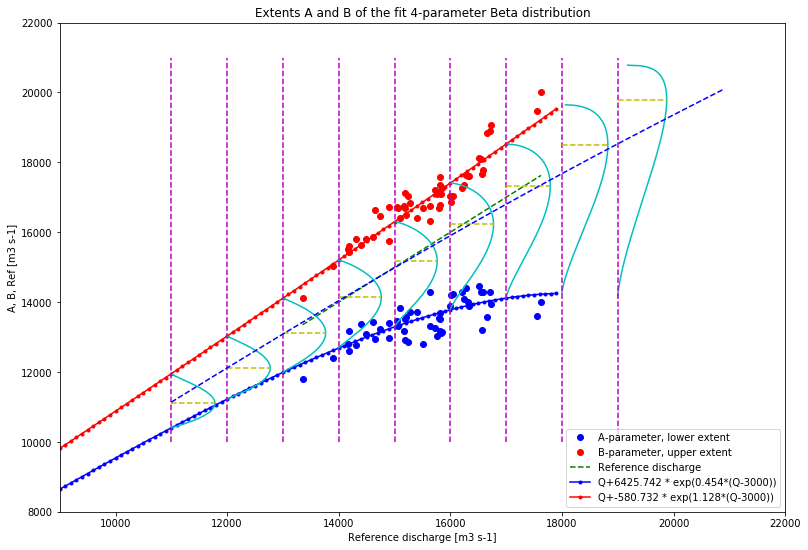

In [62]:
plt.plot(qref,a1,'bo',label='A-parameter, lower extent')
fig = plt.gcf()
ax=plt.gca()
ax.plot(qref,b1,'ro',label='B-parameter, upper extent')
ax.plot(qref,qref,'g--',label='Reference discharge')

# qs=np.array([13000,18000])
# ax.plot(qs,qs*c_a1[0]+c_a1[1],'b--',label="%.3f Q + %.1f"%tuple(c_a1))
# ax.plot(qs,qs*c_b1[0]+c_b1[1],'r--',label="%.3f Q + %.1f"%tuple(c_b1))

#logarithmic fits
qs=np.array(list(range(3000,18000,100)))
ax.plot(qs,qs-np.exp(clog_a1[0]*(qs-q0)+clog_a1[1]),'b.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_a1[1],c_a1[0],q0))
ax.plot(qs,qs+np.exp(clog_b1[0]*(qs-q0)+clog_b1[1]),'r.-',label="Q+%.3f * exp(%.3f*(Q-%.0f))"%(c_b1[1],c_b1[0],q0))


fig.set_size_inches(13,9)
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('A, B, Ref [m3 s-1]')
ax.set_title('Extents A and B of the fit 4-parameter Beta distribution')
ax.set_ylim([8000,22000])
ax.set_xlim([qr_min,qr_max])

x = np.linspace(0.0001, 1-0.0001,500)
for qr in [11000,12000,13000,14000,15000,16000,17000,18000,19000]:
    alpha = qr*c_alpha1[0]+c_alpha1[1]
    beta = qr*c_beta1[0]+c_beta1[1]
#    AA = qr*c_a1[0]+c_a1[1]
#    BB = qr*c_b1[0]+c_b1[1]
    AA = qr-np.exp(clog_a1[0]*(qr-q0)+clog_a1[1])
    BB = qr+np.exp(clog_b1[0]*(qr-q0)+clog_b1[1])
    
    plt.plot(qr+500*x**(alpha-1)*(1-x)**(beta-1)/ss.beta(alpha,beta),(BB-AA)*x+AA,'c-')
    plt.plot([qr,qr],[10000,21000],'m--')
    modus = (alpha-1)/(alpha+beta-2)
    at_modus = qr+500*modus**(alpha-1)*(1-modus)**(beta-1)/ss.beta(alpha,beta)
    plt.plot([qr,at_modus],[modus*(BB-AA)+AA,modus*(BB-AA)+AA],'y--')

modii = []
medians = []
averages = []
qrs = []
for qr in range(11000,21000,100):
    alpha = qr*c_alpha1[0]+c_alpha1[1]
    beta = qr*c_beta1[0]+c_beta1[1]
#    AA = qr*c_a1[0]+c_a1[1]
#    BB = qr*c_b1[0]+c_b1[1]
    AA = qr-np.exp(clog_a1[0]*(qr-q0)+clog_a1[1])
    BB = qr+np.exp(clog_b1[0]*(qr-q0)+clog_b1[1])
    modus = (alpha-1)/(alpha+beta-2)*(BB-AA)+AA
    median = (alpha-1./3.)/(alpha+beta-2./3.)*(BB-AA)+AA
    average = alpha/(alpha+beta)*(BB-AA)+AA
    modii.append(modus)
    medians.append(median)
    averages.append(average)
    qrs.append(qr)
# plt.plot(np.array(qrs), np.array(modii),'b--')
# plt.plot(np.array(qrs), np.array(medians),'b--')
plt.plot(np.array(qrs), np.array(averages),'b--')

ax.legend()



A and B fit using the model:
$$
A(q_r)\,=\,q_r\,-\,C_0\exp(C_1 (q_r-q_{r0})) \\
B(q_r)\,=\,q_r\,+\,D_0\exp(D_1 (q_r-q_{r0})) \\ \\
q_{r0}\,=\,3000
$$


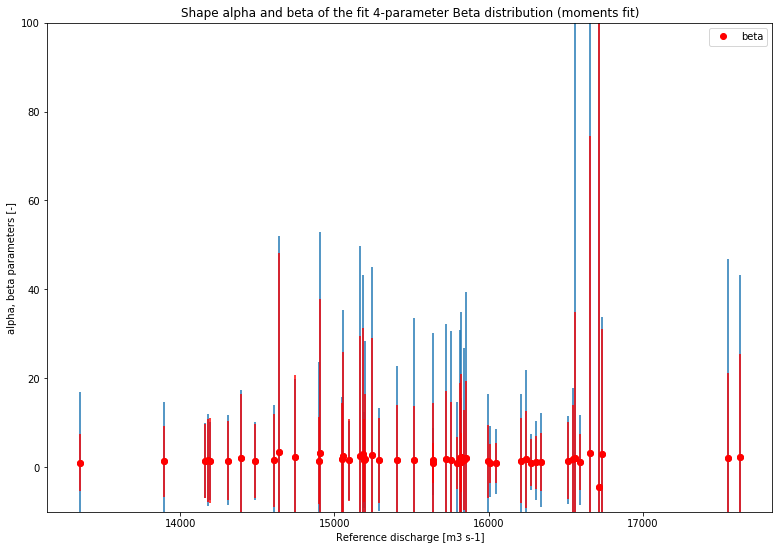

In [63]:
plt.errorbar(qref,alpha1, yerr=alpha1_2se, linestyle="")
fig = plt.gcf()
fig.set_size_inches(13,9)
plt.plot(qref,beta1,'ro',label="beta")
plt.errorbar(qref,beta1, yerr=beta1_2se, fmt='ro')
ax=plt.gca()
ax.set_ylim([-10,100])
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('alpha, beta parameters [-]')
ax.set_title('Shape alpha and beta of the fit 4-parameter Beta distribution (moments fit)')

ax.legend()

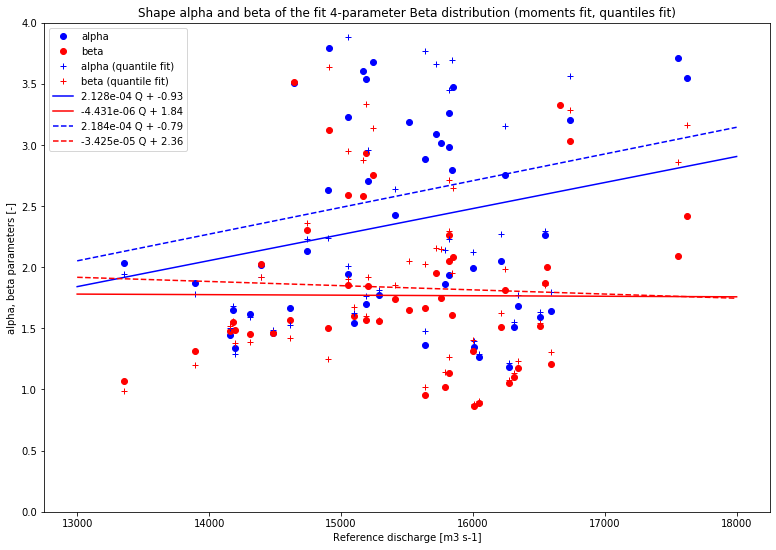

In [64]:
#plt.plot(qref,alpha1,'bo',qref,beta1,'ro',qref,alpha2,'b+',qref,beta2,'r+')

# linear fits for the quantile fits, method 2 
masked = [-7,-6,-5,-4]
alpha2_ma=ma.masked_array(alpha2)
alpha2_ma.mask=[]
beta2_ma=ma.masked_array(beta2)
beta2_ma.mask=[]
qref_ma = ma.masked_array(qref)
qref_ma.mask=[]
alpha2_ma.mask[masked] = True
beta2_ma.mask[masked] = True
qref_ma.mask[masked] = True

# linear fits for the quantile fits, method 2 
masked = [-4]
alpha1_ma=ma.masked_array(alpha1)
alpha1_ma.mask=[]
beta1_ma=ma.masked_array(beta1)
beta1_ma.mask=[]
qref_ma = ma.masked_array(qref)
qref_ma.mask=[]
alpha1_ma.mask[masked] = True
beta1_ma.mask[masked] = True
qref_ma.mask[masked] = True


plt.plot(qref,alpha1,'bo',label="alpha")
fig = plt.gcf()
fig.set_size_inches(13,9)
ax=plt.gca()
ax.plot(qref,beta1,'ro',label="beta")
ax.plot(qref,alpha2,'b+',label="alpha (quantile fit)")
ax.plot(qref,beta2,'r+',label="beta (quantile fit)")

# linear fits
c_alpha1 = linfit(qref,alpha1_ma)
c_beta1 = linfit(qref,beta1_ma)
c_alpha2 = linfit(qref_ma,alpha2_ma)
c_beta2 = linfit(qref_ma,beta2_ma)


qs=np.array([13000,18000])
ax.plot(qs,qs*c_alpha1[0]+c_alpha1[1],'b-',label="%.3e Q + %.2f"%tuple(c_alpha1))
ax.plot(qs,qs*c_beta1[0]+c_beta1[1],'r-',label="%.3e Q + %.2f"%tuple(c_beta1))
ax.plot(qs,qs*c_alpha2[0]+c_alpha2[1],'b--',label="%.3e Q + %.2f"%tuple(c_alpha2))
ax.plot(qs,qs*c_beta2[0]+c_beta2[1],'r--',label="%.3e Q + %.2f"%tuple(c_beta2))

ax.set_ylim([0,4])
ax.set_xlabel('Reference discharge [m3 s-1]')
ax.set_ylabel('alpha, beta parameters [-]')
ax.set_title('Shape alpha and beta of the fit 4-parameter Beta distribution (moments fit, quantiles fit)')

lgnd = ax.legend()

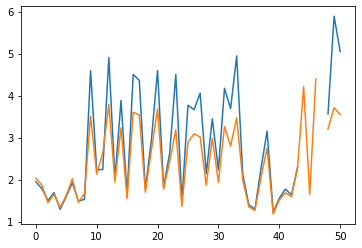

In [65]:
plt.plot(alpha2_ma)
plt.plot(alpha1_ma)


In [66]:
[key for key in ensembles.keys()]

['Scenario',
 'b24000',
 'maxQ_14199_maxV_28.8_year_3345',
 'maxQ_14210_maxV_18.1_year_2288',
 'maxQ_14256_maxV_11.5_year_3236',
 'maxQ_14434_maxV_14.1_year_3126',
 'maxQ_14450_maxV_23.4_year_3048',
 'maxQ_14567_maxV_18.9_year_7445',
 'maxQ_14594_maxV_23.3_year_9987',
 'maxQ_14756_maxV_14.5_year_7191',
 'maxQ_14808_maxV_23.1_year_9093',
 'maxQ_14848_maxV_23.6_year_7451',
 'maxQ_14995_maxV_16.0_year_9555',
 'maxQ_15047_maxV_19.1_year_3884',
 'maxQ_15162_maxV_16.9_year_2826',
 'maxQ_15199_maxV_28.2_year_5313',
 'maxQ_15333_maxV_27.9_year_3710',
 'maxQ_15408_maxV_22.6_year_9875',
 'maxQ_15494_maxV_26.5_year_8336',
 'maxQ_15579_maxV_18.8_year_2831',
 'maxQ_15690_maxV_25.2_year_2944',
 'maxQ_15769_maxV_17.6_year_2168',
 'maxQ_15936_maxV_18.6_year_8232',
 'maxQ_16210_maxV_23.0_year_3284',
 'maxQ_16252_maxV_16.7_year_3423',
 'maxQ_16499_maxV_22.5_year_6390',
 'maxQ_16537_maxV_25.4_year_8516',
 'maxQ_16656_maxV_16.8_year_6253',
 'maxQ_16675_maxV_27.6_year_7706',
 'maxQ_16808_maxV_19.1_year_932

In [67]:
results_m['maxQ_17456_maxV_24.8_year_3843']

{'estimate': array([1.34885006e+00, 8.65901155e-01, 1.42051445e+04, 1.68634596e+04]),
 'variance': array([1.56474318e+01, 4.80676221e+00, 1.86176848e+06, 1.07238544e+06]),
 'standard': 16006.58105,
 'estimate2': [1.39905, 0.882585, 14198.1, 16858.6],
 'standard2': 16006.6}

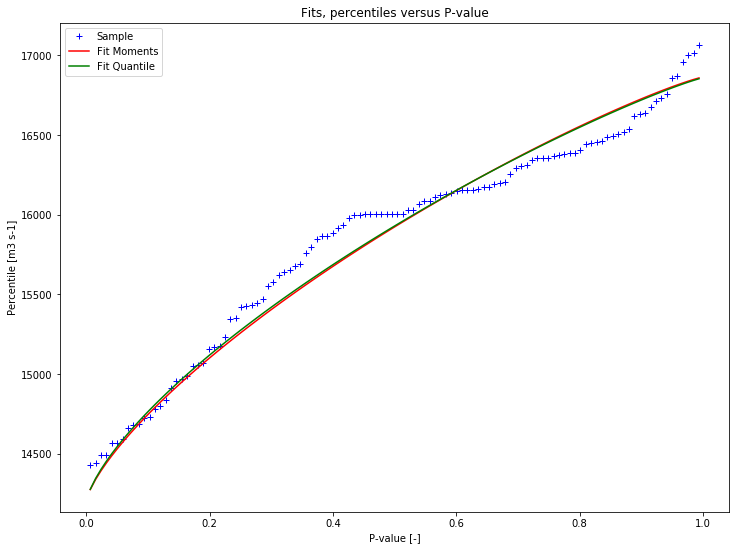

In [68]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
realization = 'maxQ_17456_maxV_24.8_year_3843'
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(12,9)
quantileplot_duo(ax1, ensembles, results_m, realization)


<hr>
<h2>Combining hydraulic and meteorological uncertainty</h2>
The final uncertainty combines the uncertainty from two sources:
<ul>
    <li> <b>Meteorological uncertainty</b><br>
        Normal distribution $N(\mu,\sigma)$, with $\mu$ and $\sigma$ depdendent on the return period.<br>
        Resulting from jackknife analysis.
    </li>
    <li> <b>Hydraulic uncertainty</b><br>
        Four parameter Beta distribution $B(\alpha,\beta,A,B)$, with all four parameters depdendent on a reference discharge $q_{ref}$, as described above, corrsponding to the 'unperturbed' simulation.<br>
    </li>
</ul>    
Combining the uncertainties modelled as follows:
<ul>
    <li> 
        The references discharge $q_r$ is modelled as a normal variable with parameters $N\left(\mu_r, \sigma_r\right)$,
        obtained for each return period from the jackknife analysis.
    </li>
    <li> The discharge $q$ is Beta-distributed with parameterss $\alpha, \beta, A, B$ dependend on $q_r$.
    </li>
</ul>    
The total distribution of $q$ (or same for the density) at a given return period can be written as an integral over $q_r$-space:
$$
    F(q)\,=\,P\left\lbrace Q\le q\right\rbrace
        \,=\,\int_0^\infty g\left(q_r;{\bf\Omega}(T)\right)H\left(q;{\bf \theta}\left(q_r\right)\right)\,dq_r
$$
$$
\,=\,\int_0^1 H\left(q;{\bf \theta}\left(G^{-1}(q;x)\right)\right)\,dx
$$
with:<br>
<ul>
    <li> $g$ the normal density with return period dependent parameter vector ${\bf \Omega}(T)$
    </li>
    <li> $H$ the Beta distribution with $q_r$-dependent parameter vector ${\bf \theta}(q_r)$
    </li>
    <li> $G^{-1}$ Normal quantile function.
    </li>
</ul>
We take $H(.)$ is the Beta distribution $H\left(q\vert\alpha,\beta,A,B\right) = B\left((q-A)/(B-A);\alpha,\beta\right)$, where $A,B,\alpha,\beta$ are functions of $q_r$.

In [43]:
# Read Rhine exreeme discharge 2021 Reference values 
with open('GRADE_RHINE_2021_REF_SBK3_GW.csv',"r") as fnin:
    qref = []
    while True:
        line = fnin.readline()
        if not line:
            break
        syear, sqvalue = line.strip().split(',')
        year = int(syear)
        qvalue = float(sqvalue)
        bisect.insort(qref,qvalue)
nx = len(qref)
np_qref = np.array(qref)
np_sgv = -np.log(-np.log((np.array(list(range(nx)))+1.-0.3)/(nx+0.4)))
np_Treturn = 1./(1.-np.exp(-np.exp(-np_sgv)))

# linear alpha and beta
np_alpha = np.array([max(1.0,c_alpha1[0]*q+c_alpha1[1]) for q in np_qref])
np_beta = np.array([max(1.0,c_beta1[0]*q+c_beta1[1]) for q in np_qref])

# linear A and B
# np_A = np.array([q*c_a1[0]+c_a1[1] for q in np_qref])
# np_B = np.array([q*c_b1[0]+c_b1[1] for q in np_qref])

# logarithmic A an B
np_A = np.array([q-np.exp(clog_a1[0]*(q-q0)+clog_a1[1]) for q in np_qref])
np_B = np.array([q+np.exp(clog_b1[0]*(q-q0)+clog_b1[1]) for q in np_qref])

# upper 97.5 percentile
np_upper = np.array([qfunbeta(np_alpha[i],np_beta[i],np_A[i],np_B[i],0.975) for i in range(nx)])
np_lower = np.array([qfunbeta(np_alpha[i],np_beta[i],np_A[i],np_B[i],0.025) for i in range(nx)])

# sigma from the beta parameters
np_sigma_beta = ((np_alpha*np_beta)/(np_alpha+np_beta)**2./(np_alpha+np_beta+1.))**0.5 * (np_B-np_A)

# dump table to file
with open('dump_beta.txt',"w") as fdump:
    for i in range(len(np_qref)):
        fdump.write("%10.4f, %10.4f, %10.4f, %10.4f, %10.4f, %10.4f, %10.4f\n"
                    %(np_sgv[i],np_Treturn[i],np_qref[i],np_alpha[i],np_beta[i],np_A[i],np_B[i]))

In [31]:
# Read old from file
with open('./oude_getallen.csv',"r") as fnin:
    sgv_list = []
    mu_list = []
    sigma_list = []
    while True:
        line = fnin.readline()
        if not line:
            break
        if line[0] in '#*':
            continue
        columns = line.strip().split(';')
        Tret = float(columns[7])
        mu_value = float(columns[8])
        sigma_value = float(columns[9])
        sgv_list.append(-np.log(-np.log(1.-1./Tret)))
        mu_list.append(mu_value)
        sigma_list.append(sigma_value)
nx_old = len(sgv_list)        
np_sgv_old = np.array(sgv_list)        
np_qref_old = np.array(mu_list)
np_sigma_old = np.array(sigma_list)    

In [32]:
np_qref_old

array([ 5940.,  7970.,  9129., 10250., 10905., 11705., 12773., 13785.,
       14004., 14400., 14835., 14974., 15268., 15520., 15700., 15839.,
       16271., 16703., 16956., 17275., 17707.])

(5000, 18000)

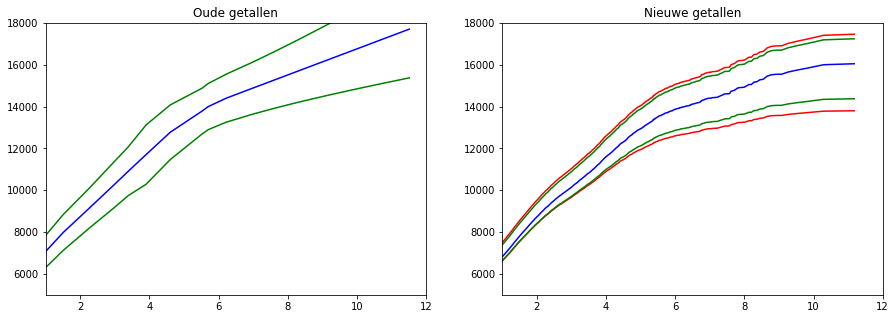

In [33]:
fig1 = plt.figure(figsize=(15,5))

ax1 = fig1.add_subplot(1, 2, 1)
pp=ax1.plot(np_sgv_old,np_qref_old,'b-')
pp=ax1.plot(np_sgv_old,np_qref_old+1.96*np_sigma_old,'g-')
pp=ax1.plot(np_sgv_old,np_qref_old-1.96*np_sigma_old,'g-')
ax1.set_title('Oude getallen')
ax1.set_xlim([1,12])
ax1.set_ylim([5000,18000])


ax2 = fig1.add_subplot(1, 2, 2)
pp=ax2.plot(np_sgv,np_qref,'b-')
pp=ax2.plot(np_sgv,np_A,'r-',np_sgv,np_B,'r-')
pp=ax2.plot(np_sgv,np_upper,'g-',np_sgv,np_lower,'g')

# pp=ax2.plot(np_sgv,np_qref+2*np_sigma_beta,'r--',np_sgv,np_qref-2*np_sigma_beta,'r--') # symmetrisch 2xse interval

ax2.set_title('Nieuwe getallen')
ax2.set_xlim([1,12])
ax2.set_ylim([5000,18000])


(3000, 20000)

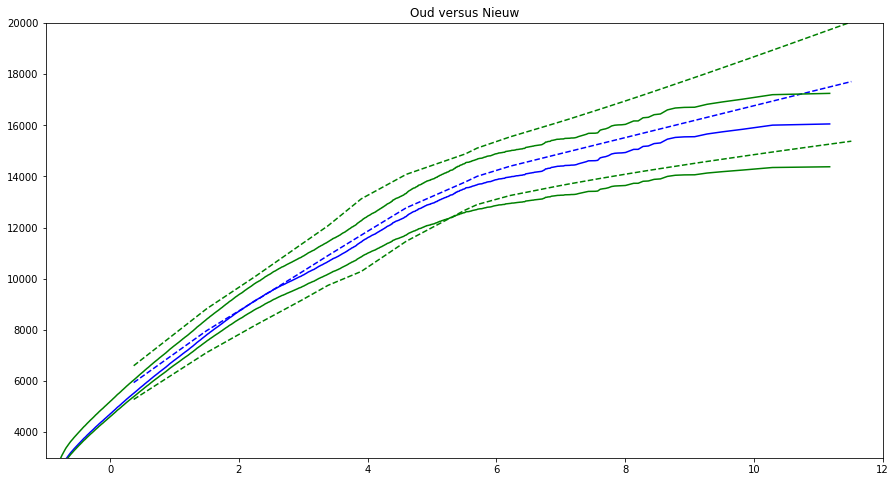

In [34]:
fig1 = plt.figure(figsize=(15,8))

ax1 = fig1.add_subplot(1, 1, 1)
pp=ax1.plot(np_sgv_old,np_qref_old,'b--')
pp=ax1.plot(np_sgv_old,np_qref_old+1.96*np_sigma_old,'g--')
pp=ax1.plot(np_sgv_old,np_qref_old-1.96*np_sigma_old,'g--')

pp=ax1.plot(np_sgv,np_qref,'b-')
# pp=ax2.plot(np_sgv,np_A,'r-',np_sgv,np_B,'r-')
pp=ax1.plot(np_sgv,np_upper,'g-',np_sgv,np_lower,'g')
ax1.set_title("Oud versus Nieuw")
ax1.set_xlim([-1,12])
ax1.set_ylim([3000,20000])

In [35]:
# Stuff for the out-itegration
def normal_cdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return (1.0 + erf((x-mu) / sigma / sqrt(2.0))) / 2.0

def normal_pdf(x,parms):
    mu = parms[0]
    sigma = parms[1]
    return exp(-0.5*((x-mu)/2./sigma)**2)/(sigma*(2*pi)**0.5)

def all_distributions(distfun, parms, levels):
    distribution = []
    for level in levels:
        distribution.append(distfun(level,parms))
    dist_np=np.array(distribution)
    return dist_np

def all_densities(densfun, parms, levels):
    densities = []
    for level in levels:
        densities.append(densfun(level,parms))
    dens_np=np.array(densities)
#   dens_np = normalise(levels, dens_np)   # ASSUMPTION THAT dens_np IS NORMALISED !!
    return dens_np

def pdf2cdf(x,pdf):
    nsections = len(x) - 1              # hekjes-paaltjes probleem
    cdf = pdf*0.0
    for i in range(len(x)-1):
        cdf[i+1] = cdf[i] + (x[i+1]-x[i])*(pdf[i+1]+pdf[i])/2.
    return cdf 

def normalise(x,f):
    total = 0.0
    nsections = len(x) - 1              # hekjes-paaltjes probleem
    for i in range(nsections):          # i runs from o through nsections -1 (zero-based index)
        total += (x[i+1]-x[i])*(f[i+1]+f[i])/2.
    f = f / (total/(1.-1./nsections))
    return (f,total)

def outintegrate_equ(parms, levels, distfun):
    # based on a sample average
    # this works if we have an evenly distributed sample (in terms of reference q) in parms
    # each record in parms consists of a tuple of parameters
    # does not have to be ordered
    nx = len(parms['distpar'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution
    cdf /= nx
    return cdf

def outintegrate(parms, levels, distfun):
    # based on a numerical integral over q probabilities
    # this works if we have an ordered set (in terms of reference q) in parms, each with its non-exceedance probability
    # each record in parms consists of a tuple of parameters AND an associated non-exceedance probability
    # has to be ordered on reference Q (that also means ordered by non-exceedance probability) 
    nx = len(parms['F'])
    nl = len(levels)
    cdf = np.array([0.0]*nl)
    H = parms['F']

    wtsum = 0.0
#   for i in range(nx):
    for i in tqdm(list(range(nx))):
        if i==0:
            wt = 0.5*(H[0]+H[1])
        elif i==nx-1:
            wt = 1.-0.5*(H[nx-1]+H[nx-2])
        else:
            wt = 0.5*(H[i+1]-H[i-1])
        wtsum = wtsum + wt
        distribution = all_distributions(distfun, parms['distpar'][i], levels)
        cdf += distribution * wt
    return cdf

In [37]:
# OutIntegration for the old numbers with the normal distribution
rijn_parms_old = {}
rijn_parms_old['F'] = np.exp(-np.exp(-np_sgv_old))
rijn_parms_old['distpar'] = [(np_qref_old[i],np_sigma_old[i]) for i in range(nx_old)]
rijn_levels_old = np.array(list(range(6000,22000,100)))
rijn_cdf_old = outintegrate(rijn_parms_old, rijn_levels_old, normal_cdf)
rijn_sgv_old = -np.log(-np.log(rijn_cdf_old))

In [39]:
# OutIntegration for the new numbers with the beta distribution
def cdfbeta(y,parms):
    return beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_parms_new = {}
rijn_parms_new['F'] = np.exp(-np.exp(-np_sgv))
rijn_parms_new['distpar'] = [(np_alpha[i],np_beta[i],np_A[i],np_B[i]) for i in range(nx)]
rijn_levels_new = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_levels_new, cdfbeta)
rijn_sgv_new = -np.log(-np.log(rijn_cdf_new))

In [40]:
np_alpha

array([1.        , 1.        , 1.        , ..., 2.44590138, 2.4801627 ,
       2.49016445])

In [524]:
# OutIntegration for the new numbers with the beta distribution but deliberately swapping shape parameters !!
def cdfbeta(y,parms):
    return beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_parms_new = {}
rijn_parms_new['F'] = np.exp(-np.exp(-np_sgv))
#rijn_parms_new['distpar'] = [(np_beta[i],np_alpha[i],np_A[i],np_B[i]) for i in range(nx)]
rijn_parms_new['distpar'] = [(1.0,2.0,np_A[i],np_B[i]) for i in range(nx)]
rijn_levels_new = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate(rijn_parms_new, rijn_levels, cdfbeta)
rijn_sgv_new2 = -np.log(-np.log(rijn_cdf_new))

In [515]:
# OutIntegration for the new numbers with the beta distribution using the iid-sample method equ !!
def cdfbeta(y,parms):
    return beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_parms_new = {}
rijn_parms_new['F'] = np.exp(-np.exp(-np_sgv))
rijn_parms_new['distpar'] = [(np_alpha[i],np_beta[i],np_A[i],np_B[i]) for i in range(nx)]
rijn_levels_new = np.array(list(range(6000,21000,100)))
rijn_cdf_new = outintegrate_equ(rijn_parms_new, rijn_levels, cdfbeta)  # The 'F''-values are ignored
rijn_sgv_new3 = -np.log(-np.log(rijn_cdf_new))

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


In [492]:
# OutIntegration for the new numbers with the normal distribution
def cdfbeta(y,parms):
    return beta_forward(parms[0],parms[1],parms[2],parms[3],y)

rijn_parms_new = {}
rijn_parms_new['F'] = np.exp(-np.exp(-np_sgv))
rijn_parms_new['distpar'] = [(np_qref[i],np_sigma_beta[i]) for i in range(nx)]
rijn_levels_new = np.array(list(range(6000,21000,100)))
rijn_cdf_new_normal = outintegrate(rijn_parms_new, rijn_levels, normal_cdf)
rijn_cdf_new_chk = outintegrate_equ(rijn_parms_new, rijn_levels, normal_cdf)
rijn_sgv_new_normal = -np.log(-np.log(rijn_cdf_new_normal))

(5000, 21000)

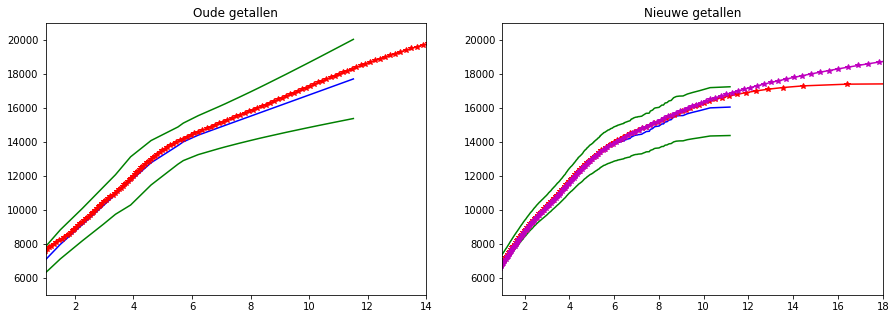

In [488]:
fig1 = plt.figure(figsize=(15,5))

ax1 = fig1.add_subplot(1, 2, 1)
pp=ax1.plot(np_sgv_old,np_qref_old,'b-')
pp=ax1.plot(np_sgv_old,np_qref_old+1.96*np_sigma_old,'g-')
pp=ax1.plot(np_sgv_old,np_qref_old-1.96*np_sigma_old,'g-')
pp=ax1.plot(rijn_sgv_old,rijn_levels,'r*-')
ax1.set_title('Oude getallen')
ax1.set_xlim([1,14])
ax1.set_ylim([5000,21000])


ax2 = fig1.add_subplot(1, 2, 2)
pp=ax2.plot(np_sgv,np_qref,'b-')
#pp=ax2.plot(np_sgv,np_A,'r-',np_sgv,np_B,'r-')
pp=ax2.plot(np_sgv,np_upper,'g-',np_sgv,np_lower,'g')
pp=ax2.plot(rijn_sgv_new,rijn_levels,'r*-')
pp=ax2.plot(rijn_sgv_new_normal,rijn_levels,'m*-')
ax2.set_title('Nieuwe getallen')
ax2.set_xlim([1,18])
ax2.set_ylim([5000,21000])


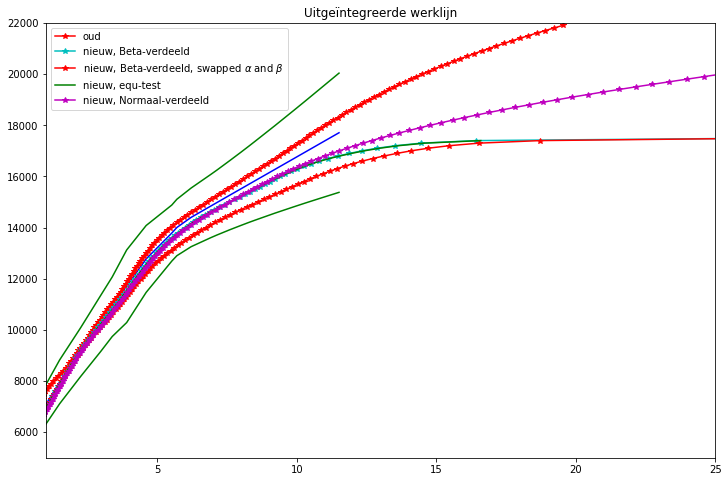

In [525]:
fig1 = plt.figure(figsize=(12,8))

ax1 = fig1.add_subplot(1, 1, 1)
pp=ax1.plot(np_sgv_old,np_qref_old,'b-')
pp=ax1.plot(np_sgv_old,np_qref_old+1.96*np_sigma_old,'g-')
pp=ax1.plot(np_sgv_old,np_qref_old-1.96*np_sigma_old,'g-')
pp=ax1.plot(rijn_sgv_old,rijn_levels,'r*-',label="oud")
pp=ax1.plot(rijn_sgv_new,rijn_levels,'c*-',label="nieuw, Beta-verdeeld")
pp=ax1.plot(rijn_sgv_new2,rijn_levels,'r*-',label=r'nieuw, Beta-verdeeld, swapped $\alpha$ and $\beta$')
pp=ax1.plot(rijn_sgv_new3,rijn_levels,'g-',label=r'nieuw, equ-test')
pp=ax1.plot(rijn_sgv_new_normal,rijn_levels,'m*-',label="nieuw, Normaal-verdeeld")
ax1.set_title('Uitgeïntegreerde werklijn')
ax1.set_xlim([1,25])
lim=ax1.set_ylim([5000,22000])
lgnd=ax1.legend()

In [500]:
rijn_sgv_new2

array([ 0.42765809,  0.47427677,  0.5209287 ,  0.56784407,  0.61546495,
        0.66329621,  0.71169248,  0.76021746,  0.80934712,  0.85891106,
        0.90846219,  0.95831579,  1.00787854,  1.05759981,  1.10819337,
        1.15890254,  1.20917225,  1.25894532,  1.30873681,  1.35822588,
        1.40739235,  1.45688029,  1.50699908,  1.55824487,  1.60976997,
        1.66208594,  1.71528935,  1.76906734,  1.82336669,  1.87808703,
        1.93343018,  1.98986071,  2.04790516,  2.10766755,  2.16896877,
        2.23286619,  2.29866085,  2.3665815 ,  2.43751829,  2.51064334,
        2.5864494 ,  2.66301995,  2.74114305,  2.82156926,  2.90290623,
        2.9855291 ,  3.06835224,  3.15004994,  3.2305202 ,  3.30944182,
        3.38690419,  3.46358877,  3.54018386,  3.61561464,  3.69086929,
        3.76550472,  3.83958074,  3.9134721 ,  3.98674323,  4.05975533,
        4.13343436,  4.20843545,  4.28492451,  4.36316795,  4.44376901,
        4.52662586,  4.61168045,  4.6989632 ,  4.78903471,  4.88

<h3>Combinatie van Beta-verdeelde en normaal-verdeelde stochasten</h3>
<b>Optie 1: Trekking uit een normale verdeling en een Beta verdeling</b>

<h3> Som van twee onafhankelijken</h3>
$${\rm Mean:\,\,\,\,}\overline{x_1\,+\,x_2}\,=\,\overline{x_1}\,+\,\overline{x_2}$$
$${\rm Variance:\,\,\,\,}\overline{(x_1\,+\,x_2)^2}\,=\,\overline{x_1}\,+\,\overline{x_2}$$

In [70]:
nx=1000
alpha=2.5
beta=1.3
sigma0 = 100.0

import fit_beta as fb

def quantiles_residuals(par,**kwargs):
    xs = np.sort(kwargs['qval'])
    fs, xx = quantilesetbeta(len(xs),par[0],par[1],par[2],par[3])
    return xs-xx
    

def update_betafit(sigma=widgets.FloatLogSlider(base=10, min=-2, max=1, step=0.01, value=0.0, continuous_update=False),alpha=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.01, value=2, continuous_update=False), beta=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.1, value=2.0, continuous_update=False)):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
#    ax1 = fig.add_subplot(1, 2, 1)
    
    DD = sigma0*(alpha+beta)*((alpha+beta+1)/(alpha*beta))**0.5     # schaalfactor
    AA = -alpha*DD/(alpha+beta)
    BB = beta*DD/(alpha+beta)
    betas=np.random.beta(alpha,beta,nx)*(BB-AA)+AA
    normals=np.random.normal(0,sigma*sigma0,nx)
    sums=betas+normals
    est2 = fb.fitBetaQuantiles(sums)
    est,var = fb.fitBetaMomentsJack(sums)
    
    plotpos=(np.array(list(range(nx)))+1.0-0.3)/(nx+0.4)
    pvalues, q_fit_m = quantilesetbeta(nx,est[0],est[1],est[2],est[3])
    pvalues2, q_fit_q = quantilesetbeta(nx,est2[0],est2[1],est2[2],est2[3])
    print(est)
    print(est2)
    ax1.plot(plotpos,np.sort(sums))
    ax1.plot(pvalues,q_fit_m,'r-')
    ax1.plot(pvalues2,q_fit_q,'g-')

    return (plt.gca)
    
interact(update_betafit)

interactive(children=(FloatLogSlider(value=0.01, continuous_update=False, description='sigma', max=1.0, min=-2…

<function __main__.update_betafit(sigma=FloatLogSlider(value=0.01, continuous_update=False, description='sigma', max=1.0, min=-2.0, step=0.01), alpha=FloatLogSlider(value=2.0, continuous_update=False, description='alpha', max=3.0, min=-2.0, step=0.01), beta=FloatLogSlider(value=2.0, continuous_update=False, description='beta', max=3.0, min=-2.0))>

interactive(children=(FloatLogSlider(value=2.0, continuous_update=False, description='alpha', max=3.0, min=-2.…

<function __main__.update_betafit(alpha=FloatLogSlider(value=2.0, continuous_update=False, description='alpha', max=3.0, min=-2.0, step=0.01), beta=FloatLogSlider(value=2.0, continuous_update=False, description='beta', max=3.0, min=-2.0))>

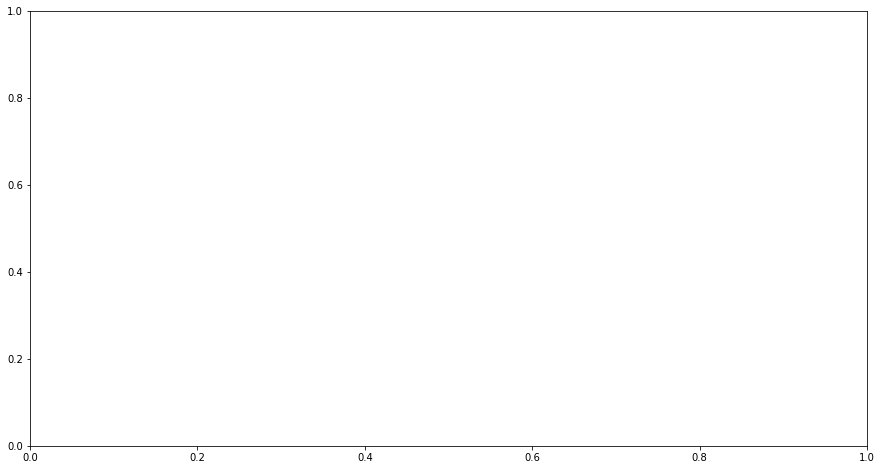

In [3]:
nx=10000
alpha=2.5
beta=1.3
sigma0 = 100.0

def update_betafit(alpha=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.01, value=2, continuous_update=False), beta=widgets.FloatLogSlider(base=10, min=-2, max=3, step=0.1, value=2.0, continuous_update=False)):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    
    DD = sigma0*(alpha+beta)*((alpha+beta+1)/(alpha*beta))**0.5     # schaalfactor
    AA = -alpha*DD/(alpha+beta)
    BB = AA + DD
    betas=np.random.beta(alpha,beta,nx)*(BB-AA)+AA
    alphas = []
    bbetas = []
    sigmas = []
    for isgm in tqdm(list(range(40))):
        sigma = isgm*10./250.
        normals=np.random.normal(0,sigma*sigma0,nx)
        sums=betas+normals
        est,var = fb.fitBetaMomentsJack(sums)
        alphas.append(est[0])
        bbetas.append(est[1])
        sigmas.append(sigma)
    ax1.plot(np.array(sigmas),np.array(alphas),'b-',label='$\alpha$')
    ax1.plot(np.array(sigmas),np.array(bbetas),'r-',label='$\beta$')
    ax1.set_title('Geschatte beta-parameters bij variërende sigma')
    ax1.set_xlabel(r'$\sigma_{normal}/\sigma_{beta}$ [-]')
    ax1.set_ylabel(r'$\alpha$, $\beta$ [-]')
    ax1.set_ylim(-5,10)
    return (plt.gca)
    
interact(update_betafit)

<h3>Regressie HBV-to-SOBEK Rijn</h3>

In [8]:
def regression_2018(x, fit_regr=False):
    c      = 342.254390
    r1     = 0.91577902
    mu1    = 14442.2780 #ORIG
    sigma1 = 307.118620
    r2     = 0.32752076
    mu2    = 18573.2200 #ORIG
    sigma2 = 2.71804449E-14
    r3     = 0.53632634 #ORIG
    mu3    = 21904.1250 #ORIG
    sigma3 = 136.807970  
    r4     = 0.21296795
    mu4    = 26177.6500 #ORIG
    sigma4 = 79.5476640
    r5     = 0.00000000
    if fit_regr == True:
        mu1    = 14800.0000
        mu2    = 17750.0000
        r3     = 0.75000000
        mu3    = 20000.0000
    
    x_ = []
    for value in x:
        z1 = (value-mu1)/sigma1
        z2 = (value-mu2)/sigma2
        z3 = (value-mu3)/sigma3
        z4 = (value-mu4)/sigma4
        
        a1 = (r1*value)
        a2 = ((r2-r1)*sigma1*np.log(1+np.exp(z1)))
        
        try:
            a3 = ((r3-r2)*sigma2*np.log(1+math.exp(z2)))
        except:
            a3 = ((r3-r2)*sigma2*z2)
        a4 = ((r4-r3)*sigma3*np.log(1+np.exp(z3)))
        a5 = ((r5-r4)*sigma4*np.log(1+np.exp(z4)))
        
        y = c + a1 + a2 + a3 + a4 + a5
        x_.append(y)

    return x_


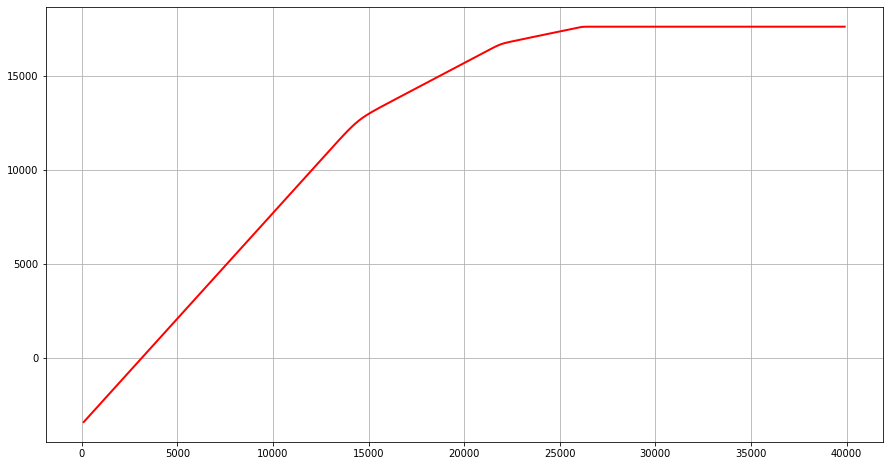

In [10]:
x = list(range(100,40000,100))
y = regression_2018(x)    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x,y,'r-',linewidth=2.0)
# ax1.plot(x,x,'--')
max_sbk=max(y)
max_sbk
# ax1.plot(ax1.get_xlim(),[max_sbk,max_sbk],'r--')
xx=np.array(x)
ax1.grid()

In [33]:
#tabelleer de regressie:
x_hbv = np.array(list(range(100,40000,100)))
y_sbk = np.array(regression_2018(x_hbv))
dydx = {'x':(x_hbv[1:]+x_hbv[:-1])*0.5,'dydx':(y_sbk[1:]-y_sbk[:-1])/(x_hbv[1:]-x_hbv[:-1])}
dxdy = {'y':(y_sbk[1:]+y_sbk[:-1])*0.5,'dxdy':(x_hbv[1:]-x_hbv[:-1])/(y_sbk[1:]-y_sbk[:-1])}

C:\Users\leander\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


$$
y(x)\,=\,
\cases{
x<x_{th}:\hspace{1cm}K\,+\,(x-x_{th})\alpha \\
x>x_{th}:\hspace{1cm}M\left(1-A \exp\left(-(x/\sigma)^\gamma\right)\right) 
}
$$
En voor de afgeleide:

$$
\frac{\partial y}{\partial x}\,=\,
\cases{
x<x_{th}:\hspace{1cm}\alpha \\
x>x_{th}:\hspace{1cm}\frac{\gamma MA}\sigma (x/\sigma)^{\gamma-1} \exp\left(-(x/\sigma)^\gamma\right)
}
$$

Continu en continu differentiëerbaar in $x_{th}$:
$$
K\,=\,M\left(1-A \exp\left(-(x_{th}/\sigma)^\gamma\right)\right)  \\
\alpha\,=\,\frac{\gamma MA}\sigma (x_{th}/\sigma)^{\gamma-1} \exp\left(-(x_{th}/\sigma)^\gamma\right)
$$

Inverse:
$$
x(y)\,=\,
\cases{
y<K:\hspace{1cm}x_{th}\,+\,\frac 1 \alpha(y\,-\,K)\\
y>K:\hspace{1cm}\sigma\left(-\log\left(\frac 1 A \left[1\,-\,\frac y M\right]\right)\right)^{1/\gamma}
}
$$

Afgeleide van de inverse:
$$
\frac{\partial x}{\partial y}\,=\,
\cases{
y<K:\hspace{1cm}1/\alpha\\
y>K:\hspace{1cm}
\frac \sigma \gamma \left(-\log\left(\frac 1 A \left[1-\frac y M\right]\right)\right)^{1/\gamma-1}
\frac A {M-y}
}
$$

De afgeleide van de inverse gaat naar oneindig als $y\uparrow M$, de bovengrens van de transformatie.
Als de invoer $x$ van de transformatie een dichtheid $f(x)$ heeft (en een verdeling $F(x)$), dan geldt
voor de dichtheid $g$ van de uitvoer $y=T(x)$:
$$
g(y) dy\,=\,f(x)dx
\,=\,
f\left(x(y)\right) \frac {dx}{dy} dy
\hspace{2cm}
\rightarrow
\hspace{2cm}
g(y)\,=\,f\left(x(y)\right) \frac {dx}{dy}
$$



In [12]:
M = 17617.7
xxth = 12000
gamma = 1.5
A = 1.4
sigma = 10656

# Voorwaartse transformatie
def diff_forward_upper(xx):
    dydx=gamma*M*A/sigma*(xx/sigma)**(gamma-1)*np.exp(-(xx/sigma)**gamma)
    return dydx

def diff_forward(xx):
    if xx>xxth:
        dxdy=diff_forward_upper(xx)
    else:
        dxdy=diff_forward_upper(xxth)
    return dxdy
    
def forward_upper(xx):
    yy=M-A*M*np.exp(-(xx/sigma)**gamma)
    return yy

def forward(xx):
    if xx>xxth:
        yy=forward_upper(xx)
    else:
        yy=forward_upper(xxth)+(xx-xxth)*diff_forward_upper(xxth)
    return yy

In [13]:
yyth = forward(xxth)

# Inverse transformatie
def diff_inverse_upper(yy):
    dxdy=(sigma/gamma)*(-np.log(1./A*(1.-yy/M)))**(1./gamma-1.)*A/(M-yy)
    return dxdy

def diff_inverse(yy):
    if yy>yyth:
        dxdy=diff_inverse_upper(yy)
    else:
        dxdy=diff_inverse_upper(yyth)
    return dxdy
    
def inverse_upper(yy):
    xx=sigma*(-np.log(1./A*(1.-yy/M)))**(1./gamma)
    return xx

def inverse(yy):
    if yy>yyth:
        xx=inverse_upper(yy)
    else:
        xx=inverse_upper(yyth)+(yy-yyth)*diff_inverse_upper(yyth)
    return xx

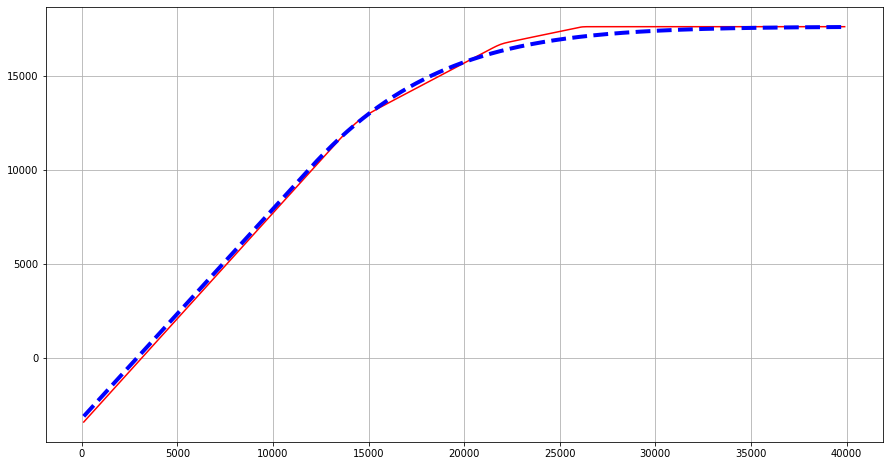

In [15]:
x = list(range(100,40000,100))
y = regression_2018(x)    
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(x,y,'r-')
# ax1.plot(x,x,'--')
max_sbk=max(y)

# ax1.plot(ax1.get_xlim(),[max_sbk,max_sbk],'r--')
xx=np.array(x)
approx=np.array([forward(xi) for xi in xx])
ax1.plot(xx,approx,'b--',linewidth=4.0)
ax1.grid()

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='mu', max=26000.0, min=5…

<function __main__.update_transform(mu=FloatSlider(value=20000.0, continuous_update=False, description='mu', max=26000.0, min=5000.0, step=100.0), sgm=FloatSlider(value=1000.0, continuous_update=False, description='sgm', max=10000.0, min=200.0, step=50.0))>

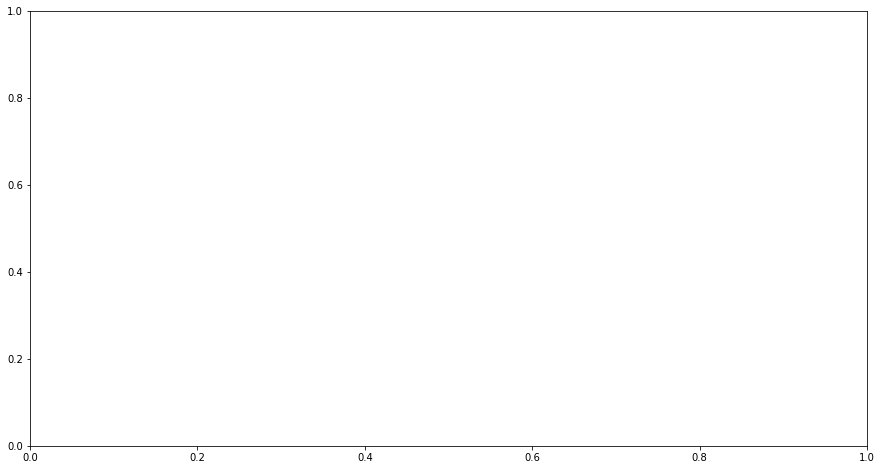

In [80]:
def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000
def update_transform(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False)):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    xpdf = normpdf(xrange,mu,sgm)
    xrange2 = xrange[xrange<max_sbk]
    ypdf = normpdf(np.array([inverse(xx) for xx in xrange2]),mu,sgm) #*np.array([diff_inverse(xx) for xx in xrange2])
    ypdf = ypdf*np.array([diff_inverse(xx) for xx in xrange2])
    ax1.plot(xrange,xpdf,'-')
    ax1.plot(xrange2,ypdf,'-')
    ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'g--')
    ax1.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax1.fill_between(xtail,0,ytail)
    
    return ax1
interact(update_transform)

In [54]:
def normpdf(xx,mu,sigma):
    return (1./(sigma*sqrt(2*pi))*np.exp(-(xx-mu)**2/2./sigma**2))

xrange = np.array(list(range(0,30000,25)))
mu0 = 20000
sigma0=1000
def update_transform2(mu=widgets.FloatSlider(min=5000, max=26000, step=100, value=mu0, continuous_update=False),sgm=widgets.FloatSlider(min=200, max=10000, step=50, value=sigma0, continuous_update=False)):
#def update_betafit(sigma=widgets.FloatSlider(min=log(0.1*sigma0), max=log(10*sigma0), step=0.01, value=sigma0, continuous_update=False)):
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    xpdf = normpdf(xrange,mu,sgm)
    xrange2 = xrange[xrange<max_sbk]
    ypdf = np.array([normpdf(interpolate(y_sbk,x_hbv,yy),mu,sgm) for yy in xrange2])
    ypdf = ypdf * np.array([interpolate(dxdy['y'],dxdy['dxdy'],yy) for yy in xrange2]) 
        
    ax1.plot(xrange,xpdf,'-')
    ax1.plot(xrange2,ypdf,'-',linewidth=4.0)
    ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'g--')
    ax1.plot(np.array([25000,25000]),np.array([0,normpdf(25000,mu,sgm)]),'r--')
    
    xtail=xrange[xrange>25000]
    ytail=xpdf[xrange>25000]
    ax1.fill_between(xtail,0,ytail)
    
    return ax1
interact(update_transform2)

interactive(children=(FloatSlider(value=20000.0, continuous_update=False, description='mu', max=26000.0, min=5…

<function __main__.update_transform2(mu=FloatSlider(value=20000.0, continuous_update=False, description='mu', max=26000.0, min=5000.0, step=100.0), sgm=FloatSlider(value=1000.0, continuous_update=False, description='sgm', max=10000.0, min=200.0, step=50.0))>

In [60]:
nx0=10000
nbin0=1000

def update_histogram(mu_hbv=widgets.FloatSlider(min=10000, max=25000, step=500, value=15000, continuous_update=False),sigma_hbv=widgets.FloatSlider(min=100, max=10000, step=500, value=1000, continuous_update=False)):
    nx = nx0
    nbin = nbin0
    fig = plt.figure(figsize=(15,8))
    ax1 = fig.add_subplot(1, 1, 1)
    q_hbv=np.random.normal(mu_hbv,sigma_hbv,nx)
    q_sbk=regression_2018(q_hbv)
    result_hbv = ax1.hist(q_hbv, bins = nbin, density=True)
    result_sbk = ax1.hist(q_sbk, bins = nbin, density=True)
    ax1.set_xlim(9000,35000)
    ax1.set_ylim(0,0.00012)
#   ax1.plot([max_sbk,max_sbk],ax1.get_ylim(),'r--')
    print(sum(result_hbv[0]))
    return (ax1)
    
interact(update_histogram)

interactive(children=(FloatSlider(value=15000.0, continuous_update=False, description='mu_hbv', max=25000.0, m…

<function __main__.update_histogram(mu_hbv=FloatSlider(value=15000.0, continuous_update=False, description='mu_hbv', max=25000.0, min=10000.0, step=500.0), sigma_hbv=FloatSlider(value=1000.0, continuous_update=False, description='sigma_hbv', max=10000.0, min=100.0, step=500.0))>

In [84]:
max(y)

17617.734792824936